In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem
import pickle
import seaborn as sns
import pandas as pd
from scipy.stats import norm
from scipy.stats import ttest_ind, ttest_rel
import sys

sys.path.append('..')
from familiarity.config import DATA_DIR


def reject_outliers(all_results_no_train):
    bad_trials = []
    for ii in range(len(all_results_no_train)):
        for ses in range(1,5):
            ses_trials = np.logical_and(all_results_no_train.system == 'human', 
                                        all_results_no_train.session == f'unfamiliar-{ses}')
            if ii in np.nonzero(ses_trials)[0]:
                if all_results_no_train.iloc[ii].dprime < (
                    np.mean(all_results_no_train[ses_trials].dprime) - 
                    2*np.std(all_results_no_train[ses_trials].dprime)
                ):
                    bad_trials.append(ii)
                    print(f"rejecting sub-{all_results_no_train.iloc[ii].subject} ses-{all_results_no_train.iloc[ii].session}")
    all_results_no_train = all_results_no_train.drop(all_results_no_train.index[bad_trials])


subs_fulltraining = ['02', '07']
subs_skipmontages=['03', '08', '09', '10', '14', '17', '18'] #sub 3 was instructed to skip before skipmontage version was created
subs_notraining=['11', '12', '13', '15', '16', '19', '20', '21'] + [str(num) for num in range(22,37)]
other_subs=['01', '05', '06'] # subs 1,5,6 did not finish training. sub 1 also had incorrect stimulus pairs. 13, 21 didnt try.

subs_training= subs_fulltraining + subs_skipmontages
trials_per_sub=[150] + np.repeat(100, (len(subs_training)-1,)).tolist()

imset = 'australian-celebs'
im_selection_net = 'vgg_face_dag'
comparison_net = 'vgg16_train-vggface2'
recog_tag = '_recog-sim'
data_dir=os.path.join(DATA_DIR, 'face_matching')
# recog_tag = ''

# Behavioral results and layer-specific modeling (3.9)

In [2]:
all_results_no_train = {'system':[], 'familiar':[], 'subject':[], 'session':[], 'AUC':[], 'dprime':[]}
for sub in subs_notraining:
    for ses in range(1,5):
        compnet = comparison_net + '-finetuned' if ses > 1 else comparison_net
        sub_fn = f"{data_dir}/processed/sub-{sub}_ses-{ses}_imset-{imset}_selected-{im_selection_net}_tested-{compnet}{recog_tag}.pkl"
        sub_fn_unfam = f"{data_dir}/processed/sub-{sub}_ses-{ses}_imset-{imset}_selected-{im_selection_net}_tested-{comparison_net}{recog_tag}.pkl"
        if os.path.exists(sub_fn):
            with open(sub_fn, 'rb') as f:
                results = pickle.load(f)
            with open(sub_fn_unfam, 'rb') as f:
                res_unfam = pickle.load(f)
            # human
            all_results_no_train['subject'].append(sub)
            all_results_no_train['system'].append('human')
            all_results_no_train['session'].append(f'unfamiliar-{ses}')
            all_results_no_train['familiar'].append(False)
            all_results_no_train['AUC'].append(results['AUC']) 
            all_results_no_train['dprime'].append(np.sqrt(2)*norm.ppf(results['AUC'])) 
            # DCNN
            all_results_no_train['subject'].append(None)
            all_results_no_train['system'].append('DCNN')
            all_results_no_train['session'].append(f'unfamiliar-{ses}')
            all_results_no_train['familiar'].append(ses>1)
            all_results_no_train['AUC'].append(res_unfam['DCNN']['accs'][-2])
            all_results_no_train['dprime'].append(np.sqrt(2)*norm.ppf(res_unfam['DCNN']['accs'][-2])) 
            if ses == 4:
                all_results_no_train['subject'].append(None)
                all_results_no_train['system'].append('DCNN')
                all_results_no_train['session'].append('familiar')
                all_results_no_train['familiar'].append(True)
                all_results_no_train['AUC'].append(results['DCNN']['accs'][-2])
                all_results_no_train['dprime'].append(np.sqrt(2)*norm.ppf(results['DCNN']['accs'][-2]))            
            
            # also take sub-wise difference b/w DCNN and human
            all_results_no_train['subject'].append(None)
            all_results_no_train['system'].append('difference')
            all_results_no_train['session'].append(f'unfamiliar-{ses}')
            all_results_no_train['familiar'].append(ses>1)
            all_results_no_train['AUC'].append(results['AUC'] - res_unfam['DCNN']['accs'][-2]) 
            all_results_no_train['dprime'].append(
                np.sqrt(2)*norm.ppf(results['AUC']) - np.sqrt(2)*norm.ppf(res_unfam['DCNN']['accs'][-2])) 
all_results_no_train = pd.DataFrame(all_results_no_train)

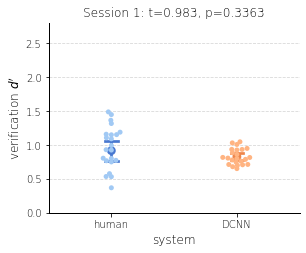

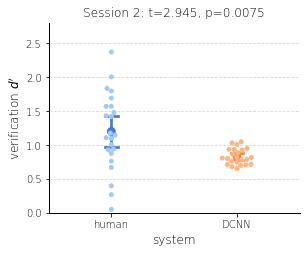

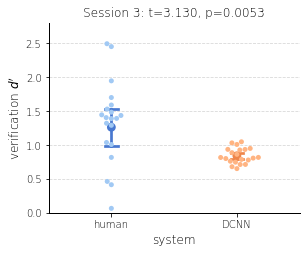

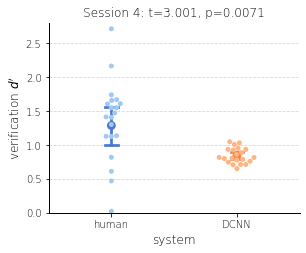

In [3]:
for session in range(1,5):
    human = all_results_no_train.dprime[np.logical_and(np.equal(all_results_no_train.system,'human'),[ses in [f'unfamiliar-{session}'] for ses in all_results_no_train.session])]
    dcnn = all_results_no_train.dprime[np.logical_and(np.equal(all_results_no_train.system,'DCNN'),[ses in ['unfamiliar-1'] for ses in all_results_no_train.session])]
    if len(dcnn) > len(human):
        dcnn = dcnn[0:len(human)]
    t, p = ttest_rel(human, dcnn)
    fig, ax = plt.subplots(figsize=(4.5,3.5))
    sns.swarmplot(x="system", y='dprime', order=['human', 'DCNN'],
                    data=all_results_no_train[all_results_no_train.session == f'unfamiliar-{session}'],             
                  dodge=True, ax=ax, palette='pastel')
    sns.pointplot(x="system", y="dprime", order=['human','DCNN'], linestyles='',
                  data=all_results_no_train[all_results_no_train.session == f'unfamiliar-{session}'], 
                  capsize=0.1, ax=ax, palette='muted', dodge=True)
    ax.set_ylim([0,2.8])
    plt.title(rf'Session {session}: t={t:.03f}, p={p:.04f}')
    plt.ylabel("verification $d'$")
    plt.savefig(f'../figures/face_matching/ses-{session}_human_dcnn')
    plt.show()

In [4]:
all_results_no_train = {'system':[], 'familiar':[], 'session':[], 'AUC':[], 'dprime':[]}
for sub in subs_notraining:
    for ses in range(1,5):
        compnet = comparison_net + '-finetuned' if ses > 1 else comparison_net
        sub_fn = f"{data_dir}/processed/sub-{sub}_ses-{ses}_imset-{imset}_selected-{im_selection_net}_tested-{compnet}{recog_tag}.pkl"
        sub_fn_unfam = f"{data_dir}/processed/sub-{sub}_ses-{ses}_imset-{imset}_selected-{im_selection_net}_tested-{comparison_net}{recog_tag}.pkl"
        if os.path.exists(sub_fn):
            with open(sub_fn, 'rb') as f:
                results = pickle.load(f)
            with open(sub_fn_unfam, 'rb') as f:
                res_unfam = pickle.load(f)
            # human
            all_results_no_train['system'].append('human')
            all_results_no_train['session'].append(f'unfamiliar-{ses}')
            all_results_no_train['familiar'].append(False)
            all_results_no_train['AUC'].append(results['AUC']) 
            all_results_no_train['dprime'].append(np.sqrt(2)*norm.ppf(results['AUC'])) 
            # DCNN
            if ses == 1:
                all_results_no_train['system'].append('DCNN')
                all_results_no_train['session'].append(f'unfamiliar-{ses}')
                all_results_no_train['familiar'].append(ses>1)
                all_results_no_train['AUC'].append(res_unfam['DCNN']['accs'][-2])
                all_results_no_train['dprime'].append(np.sqrt(2)*norm.ppf(res_unfam['DCNN']['accs'][-2])) 
            if ses == 4:
                all_results_no_train['system'].append('DCNN')
                all_results_no_train['session'].append('familiar')
                all_results_no_train['familiar'].append(True)
                all_results_no_train['AUC'].append(results['DCNN']['accs'][-2])
                all_results_no_train['dprime'].append(np.sqrt(2)*norm.ppf(results['DCNN']['accs'][-2]))            
            
            # also take sub-wise difference b/w DCNN and human
            all_results_no_train['system'].append('difference')
            all_results_no_train['session'].append(f'unfamiliar-{ses}')
            all_results_no_train['familiar'].append(ses>1)
            all_results_no_train['AUC'].append(results['AUC'] - res_unfam['DCNN']['accs'][-2]) 
            all_results_no_train['dprime'].append(
                np.sqrt(2)*norm.ppf(results['AUC']) - np.sqrt(2)*norm.ppf(res_unfam['DCNN']['accs'][-2])) 
all_results_no_train = pd.DataFrame(all_results_no_train)

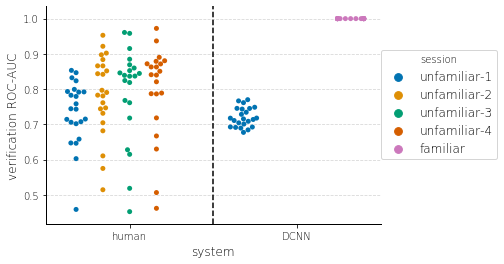

In [5]:
fig, ax = plt.subplots()
sns.swarmplot(x="system", y='AUC', order=['human', 'DCNN'], 
                hue='session', hue_order=['unfamiliar-1', 'unfamiliar-2', 'unfamiliar-3','unfamiliar-4', 'familiar'],
                data=all_results_no_train,                  
              dodge=True, ax=ax, palette='colorblind')
# sns.pointplot(x="system", y="AUC", order=['human','DCNN'], hue='session',linestyles='',
#               data=all_results_no_train, 
#               capsize=0.1, ax=ax, palette='muted', dodge=True)
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:5], labels[0:5], bbox_to_anchor=(1, 0.8), title='session',loc=2, borderaxespad=0., fontsize='large')
ax.axvline(0.5, color='k', linestyle='--')
plt.ylabel('verification ROC-AUC')
plt.savefig('../figures/face_matching/all_sessions_human_dcnn', bbox_inches='tight')


In [6]:
all_results_no_train = {'system':[], 'familiar':[], 'session':[], 'AUC':[], 'dprime':[]}
for sub in subs_notraining:
    for ses in range(1,5):
        compnet = comparison_net + '-finetuned' if ses > 1 else comparison_net
        sub_fn = f"{data_dir}/processed/sub-{sub}_ses-{ses}_imset-{imset}_selected-{im_selection_net}_tested-{compnet}{recog_tag}.pkl"
        sub_fn_unfam_obj = f"{data_dir}/processed/sub-{sub}_ses-{ses}_imset-{imset}_selected-{im_selection_net}_tested-vgg16_train-imagenet-subset{recog_tag}.pkl"
        sub_fn_unfam_face = f"{data_dir}/processed/sub-{sub}_ses-{ses}_imset-{imset}_selected-{im_selection_net}_tested-vgg16_train-vggface2{recog_tag}.pkl"
        if os.path.exists(sub_fn):
            with open(sub_fn, 'rb') as f:
                results = pickle.load(f)
            with open(sub_fn_unfam_obj, 'rb') as f:
                res_unfam_obj = pickle.load(f)
            with open(sub_fn_unfam_face, 'rb') as f:
                res_unfam_face = pickle.load(f)                
                
            # human
            if ses == 1:
                all_results_no_train['system'].append('human_unfam')
            else:
                all_results_no_train['system'].append(f'human_unfam_ses-{ses}')
            all_results_no_train['session'].append(f'unfamiliar-{ses}')
            all_results_no_train['familiar'].append(False)
            all_results_no_train['AUC'].append(results['AUC']) 
            all_results_no_train['dprime'].append(np.sqrt(2)*norm.ppf(results['AUC'])) 
            # DCNN
            if ses == 1:
                all_results_no_train['system'].append('face_DCNN_unfam')
                all_results_no_train['session'].append(f'unfamiliar-{ses}')
                all_results_no_train['familiar'].append(ses>1)
                all_results_no_train['AUC'].append(res_unfam_face['DCNN']['accs'][-2])
                all_results_no_train['dprime'].append(np.sqrt(2)*norm.ppf(res_unfam_face['DCNN']['accs'][-2])) 
                
                all_results_no_train['system'].append('object_DCNN_unfam')
                all_results_no_train['session'].append(f'unfamiliar-{ses}')
                all_results_no_train['familiar'].append(ses>1)
                all_results_no_train['AUC'].append(res_unfam_obj['DCNN']['accs'][-2])
                all_results_no_train['dprime'].append(np.sqrt(2)*norm.ppf(res_unfam_obj['DCNN']['accs'][-2])) 
                
#             if ses == 4:
#                 all_results_no_train['system'].append('face_DCNN_fam')
#                 all_results_no_train['session'].append('familiar')
#                 all_results_no_train['familiar'].append(True)
#                 all_results_no_train['AUC'].append(results['DCNN']['accs'][-2])
#                 all_results_no_train['dprime'].append(np.sqrt(2)*norm.ppf(results['DCNN']['accs'][-2]))            
            
            # also take sub-wise difference b/w DCNN and human
            all_results_no_train['system'].append('difference')
            all_results_no_train['session'].append(f'unfamiliar-{ses}')
            all_results_no_train['familiar'].append(ses>1)
            all_results_no_train['AUC'].append(results['AUC'] - res_unfam['DCNN']['accs'][-2]) 
            all_results_no_train['dprime'].append(
                np.sqrt(2)*norm.ppf(results['AUC']) - np.sqrt(2)*norm.ppf(res_unfam['DCNN']['accs'][-2])) 
all_results_no_train = pd.DataFrame(all_results_no_train)

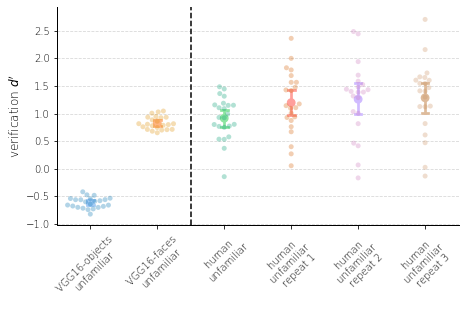

In [7]:
labels = ['object_DCNN_unfam', 'face_DCNN_unfam', 'human_unfam', 'human_unfam_ses-2', 'human_unfam_ses-3', 'human_unfam_ses-4']
renamed= ['VGG16-objects \nunfamiliar', 'VGG16-faces \nunfamiliar', 'human \nunfamiliar', 'human \nunfamiliar \nrepeat 1', 'human \nunfamiliar \nrepeat 2', 'human \nunfamiliar \nrepeat 3']
fig, ax = plt.subplots(figsize=((6/5)*len(labels),4))
sns.swarmplot(x="system", y='dprime', order=labels, alpha=0.3, 
                data=all_results_no_train,                  
              dodge=True, ax=ax, palette='colorblind')
sns.pointplot(x="system", y='dprime', order=labels,
                data=all_results_no_train,                  
              capsize=0.1, dodge=True, ax=ax, palette='pastel')
handles, labels = ax.get_legend_handles_labels()
plt.xticks(rotation=45, ticks = ax.get_xticks(), labels=renamed)
ax.axvline(1.5, color='k', linestyle='--')
plt.ylabel(r"verification $d'$")
plt.xlabel('')
plt.savefig('../figures/face_matching/all_sessions_human_dcnn_unfam.png', dpi=400, bbox_inches='tight')
plt.show()

# Modeling behavioral results with a flexible cognitive rule combining penultimate and output representations

In [8]:
all_results_no_train = {'system':[], 'familiar':[], 'AUC':[], 'dprime':[]}
for sub in subs_notraining:
        sub_fn_face = f"{data_dir}/full_verification/sub-{sub}_comp-vgg16_train-vggface2-match-imagenet-subset_recog.pkl"
        sub_fn_obj = f"{data_dir}/full_verification/sub-{sub}_comp-vgg16_train-imagenet-subset_recog.pkl"
        
        if not os.path.exists(sub_fn_face) or not os.path.exists(sub_fn_obj):
            print(f'did not find sub-{sub}')
            continue
        with open(sub_fn_obj, 'rb') as f:
            res_unfam_obj = pickle.load(f)
        with open(sub_fn_face, 'rb') as f:
            res_unfam_face = pickle.load(f)   
                
        for familiarity in ['unfamiliar', 'familiar']:
            all_results_no_train['system'].append(f'face_DCNN_{familiarity}')
            all_results_no_train['familiar'].append(familiarity == 'familiar')
            all_results_no_train['AUC'].append(np.mean(res_unfam_face[familiarity]['auc']))
            all_results_no_train['dprime'].append(np.mean(res_unfam_face[familiarity]['dprime']))
            
            all_results_no_train['system'].append(f'object_DCNN_{familiarity}')
            all_results_no_train['familiar'].append(familiarity == 'familiar')
            all_results_no_train['AUC'].append(np.mean(res_unfam_obj[familiarity]['auc']))
            all_results_no_train['dprime'].append(np.mean(res_unfam_obj[familiarity]['dprime']))            

all_results_no_train = pd.DataFrame(all_results_no_train)

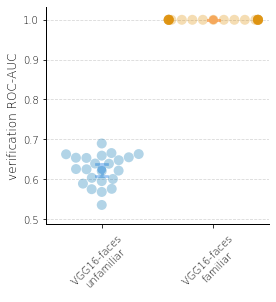

In [9]:
# labels = ['object_DCNN_unfamiliar', 'face_DCNN_unfamiliar', 'object_DCNN_familiar', 'face_DCNN_familiar']
# renamed= ['VGG16-objects \nunfamiliar', 'VGG16-faces \nunfamiliar', 'VGG16-objects \nfamiliar', 'VGG16-faces \nfamiliar']
labels = ['face_DCNN_unfamiliar', 'face_DCNN_familiar']
renamed= [ 'VGG16-faces \nunfamiliar', 'VGG16-faces \nfamiliar']
fig, ax = plt.subplots(figsize=(4,4))
sns.swarmplot(x="system", y='AUC', order=labels, alpha=0.3, 
                data=all_results_no_train, size=10,             
              dodge=True, ax=ax, palette='colorblind')
sns.pointplot(x="system", y='AUC', order=labels,
                data=all_results_no_train,                  
              capsize=0.1, dodge=True, ax=ax, palette='pastel')
handles, labels = ax.get_legend_handles_labels()
plt.xticks(rotation=45, ticks = ax.get_xticks(), labels=renamed)
plt.ylabel(r"verification ROC-AUC")
plt.xlabel('')
plt.savefig('../figures/face_matching/cognitive_rule.png', dpi=400, bbox_inches='tight')
plt.show()